In [1]:
import scipy
import os
import warnings
import numpy as np
from model import DGN
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torch.nn
import contextlib
import sys


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Arial', 'Liberation Serif']

#### 1. inspect

In [2]:
data = np.load("simulated_dataset/example.npy")

In [3]:
mat_data = scipy.io.loadmat('data_nc_asd_R/data_nc_asd_R/ASD_RH/RHASDSub1.mat')
connectivity_matrix = mat_data['views']

In [4]:
fold0_all_cbt_data = np.load("output/DGN_TEST/fold0_all_cbts.npy")
fold0_cbt_data = np.load("output/DGN_TEST/fold0_cbt.npy")

#### 2. data preprocessing

In [5]:
def normalize_matrix(connectivity_matrix):
    np.fill_diagonal(connectivity_matrix, 0)
    connectivity_matrix[np.logical_or(np.isinf(connectivity_matrix), np.isnan(connectivity_matrix))] = 0
    connectivity_matrix = connectivity_matrix.astype(float)
    
    return connectivity_matrix

In [6]:
import scipy.io
import numpy as np

connectivity_matrices_asd = []

for i in range(1, 155):
    mat = scipy.io.loadmat(f'data_nc_asd_R/data_nc_asd_R/ASD_RH/RHASDSub{i}.mat')
    connectivity_matrix = mat['views'][:, :, :]
    connectivity_matrix = [normalize_matrix(mat) for mat in connectivity_matrix]
    connectivity_matrices_asd.append(connectivity_matrix)

connectivity_matrices_asd = np.stack(connectivity_matrices_asd)

connectivity_matrices_control = []

for i in range(1, 186):
    mat = scipy.io.loadmat(f'data_nc_asd_R/data_nc_asd_R/NC_RH/RHNCSub{i}.mat')
    connectivity_matrix = mat['views'][:, :, :]
    connectivity_matrix = [normalize_matrix(mat) for mat in connectivity_matrix]
    connectivity_matrices_control.append(connectivity_matrix)

connectivity_matrices_control = np.stack(connectivity_matrices_control)


In [7]:
warnings.filterwarnings("ignore", category=UserWarning)

#### 3. train DGN for ASD

In [8]:
Dataset = "E" 

#Number of simulated subjects (overwriten if Dataset = "E") 
N_Subjects = 20

#Number of nodes for simulated brain networks (overwriten if Dataset = "E") 
N_Nodes = 35

#Number of brain views (overwriten if Dataset = "E")
N_views = 6

#Number of training epochs
N_max_epochs = 500

#Apply early stopping True/False
early_stop =  True

#Random subset size for SNL function  
random_sample_size = 10

#Number of cross validation folds
n_folds = 3

#Learning Rate for Adam optimizer
lr = 0.0005

#Name of the model
model_name = "DGN_ASD"

#dimension of embeddings output by the first GDL layer (for each ROI)
CONV1 = 8
#dimension of embeddings output by the second GDL layer (for each ROI)
CONV2 = 8
#dimension of embeddings output by the third GDL layer (for each ROI)
CONV3 = 8

lambda_w_out = 200

#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#
#                 Below is not to be modified manually                       #
#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#

import helper

if Dataset.lower() not in ["e", "E", "s", "S"]:
    raise ValueError("Dataset options are E or S.")
    
if (Dataset.lower() == "e"):
    X = connectivity_matrices_asd[0::8]
    N_Subjects = X.shape[0]
    N_Nodes = X.shape[1]
    N_views = X.shape[3]
else:
    X = helper.create_better_simulated(N_Subjects, N_Nodes) if N_views == 4 else helper.simulate_dataset(N_Subjects, N_Nodes, N_views)


CONFIG = {
        "X": X,
        "N_ROIs":  X.shape[1],
        "N_views":  X.shape[3],
        "N_max_epochs": N_max_epochs,
        "n_folds": n_folds,
        "random_sample_size": random_sample_size,
        "early_stop": early_stop,
        "model_name": model_name
    }

MODEL_PARAMS = {
        "N_ROIs": N_Nodes,
        "learning_rate" : lr,
        "n_attr": X.shape[3],
        "Linear1" : {"in": N_views, "out": CONV1},
        "conv1": {"in" : 1, "out": CONV1},
        
        "Linear2" : {"in": N_views, "out": CONV1*CONV2},
        "conv2": {"in" : CONV1, "out": CONV2},
        
        "Linear3" : {"in": N_views, "out": CONV2*CONV3},
        "conv3": {"in" : CONV2, "out": CONV3},
    }

In [9]:
models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])

********* FOLD 0 *********
Epoch: 0  |  cbt loss : 27.18 | reservoir loss : 0.1062102966 | bio loss : 0.89830 | total loss: 36.58 | median cbt mc 9.92 | Time Elapsed: 6.10 | 
Epoch: 10  |  cbt loss : 22.02 | reservoir loss : 0.1046673455 | bio loss : 0.67162 | total loss: 31.06 | median cbt mc 10.18 | Time Elapsed: 46.18 | 
Epoch: 20  |  cbt loss : 18.99 | reservoir loss : 0.1031827053 | bio loss : 0.49652 | total loss: 27.74 | median cbt mc 10.18 | Time Elapsed: 50.03 | 
Epoch: 30  |  cbt loss : 17.21 | reservoir loss : 0.1017620324 | bio loss : 0.00285 | total loss: 25.35 | median cbt mc 10.20 | Time Elapsed: 44.89 | 
Epoch: 40  |  cbt loss : 15.91 | reservoir loss : 0.1004082777 | bio loss : 0.00952 | total loss: 23.95 | median cbt mc 10.16 | Time Elapsed: 46.37 | 
Epoch: 50  |  cbt loss : 14.75 | reservoir loss : 0.0991221314 | bio loss : 0.00032 | total loss: 22.68 | median cbt mc 10.20 | Time Elapsed: 46.58 | 
Epoch: 60  |  cbt loss : 14.00 | reservoir loss : 0.0979028486 | bio l

KeyboardInterrupt: 

In [ ]:
output_file_path = 'output/output_log_20_early_stopping4.txt'

# Using contextlib.redirect_stdout and contextlib.redirect_stderr
with open(output_file_path, 'w') as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
    # Check if directories exist and create them if not
    if not os.path.exists('temp_asd'):
        os.makedirs('temp_asd')
        print("'temp_asd' directory created.")
    if not os.path.exists('output_asd'):
        os.makedirs('output_asd')  
        print("'output_asd' directory created.")

    # Assuming DGN.train_model() prints its output
    models = DGN.train_model(
                    CONFIG["X"],
                    model_params=MODEL_PARAMS,
                    n_max_epochs=CONFIG["N_max_epochs"],
                    n_folds=CONFIG["n_folds"],
                    random_sample_size=CONFIG["random_sample_size"],
                    early_stop=CONFIG["early_stop"],
                    model_name=CONFIG["model_name"])
    print("Model training completed.")

KeyboardInterrupt: 

In [ ]:
if not os.path.exists('temp_asd'):
    os.makedirs('temp_asd')
if not os.path.exists('output_asd'):
    os.makedirs('output_asd')  

models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])

********* FOLD 0 *********
Epoch: 0  |  cbt loss : 26.36 | reservoir loss : 0.1108582541 | bio loss : 0.01061 | total loss: 37.45 | Time Elapsed: 3.89 | 
Epoch: 10  |  cbt loss : 18.54 | reservoir loss : 0.1108582020 | bio loss : 0.00357 | total loss: 29.63 | Time Elapsed: 17.65 | 
Epoch: 20  |  cbt loss : 15.49 | reservoir loss : 0.1108582169 | bio loss : 0.00139 | total loss: 26.58 | Time Elapsed: 17.76 | 
Epoch: 30  |  cbt loss : 13.64 | reservoir loss : 0.1108582318 | bio loss : 0.00049 | total loss: 24.73 | Time Elapsed: 17.94 | 
Epoch: 40  |  cbt loss : 12.69 | reservoir loss : 0.1108582020 | bio loss : 0.00160 | total loss: 23.78 | Time Elapsed: 18.01 | 
Epoch: 50  |  cbt loss : 12.10 | reservoir loss : 0.1108581647 | bio loss : 0.00212 | total loss: 23.19 | Time Elapsed: 17.73 | 
Epoch: 60  |  cbt loss : 11.67 | reservoir loss : 0.1108582318 | bio loss : 0.00079 | total loss: 22.75 | Time Elapsed: 17.84 | 
Epoch: 70  |  cbt loss : 11.34 | reservoir loss : 0.1108582318 | bio los

In [ ]:
if not os.path.exists('temp_asd'):
    os.makedirs('temp_asd')
if not os.path.exists('output_asd'):
    os.makedirs('output_asd')  

models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])

********* FOLD 0 *********
Epoch: 0  |  Test Rep : 26.59|  Test Rep + 10W_out + 10bio: 36.37 | W_out : 0.0899940953 | bio_loss : 0.77883 |  Time Elapsed: 5.20  |
Epoch: 10  |  Test Rep : 18.77|  Test Rep + 10W_out + 10bio: 27.78 | W_out : 0.0899940953 | bio_loss : 0.01138 |  Time Elapsed: 36.86  |
Epoch: 20  |  Test Rep : 15.78|  Test Rep + 10W_out + 10bio: 24.78 | W_out : 0.0899940953 | bio_loss : 0.00103 |  Time Elapsed: 34.69  |
Epoch: 30  |  Test Rep : 13.86|  Test Rep + 10W_out + 10bio: 22.86 | W_out : 0.0899940953 | bio_loss : 0.00121 |  Time Elapsed: 34.42  |
Epoch: 40  |  Test Rep : 12.90|  Test Rep + 10W_out + 10bio: 21.91 | W_out : 0.0899940953 | bio_loss : 0.00901 |  Time Elapsed: 33.71  |
Epoch: 50  |  Test Rep : 12.29|  Test Rep + 10W_out + 10bio: 21.29 | W_out : 0.0899940953 | bio_loss : 0.00097 |  Time Elapsed: 36.22  |
Epoch: 60  |  Test Rep : 11.86|  Test Rep + 10W_out + 10bio: 20.86 | W_out : 0.0899940953 | bio_loss : 0.00073 |  Time Elapsed: 36.10  |
Epoch: 70  |  Te

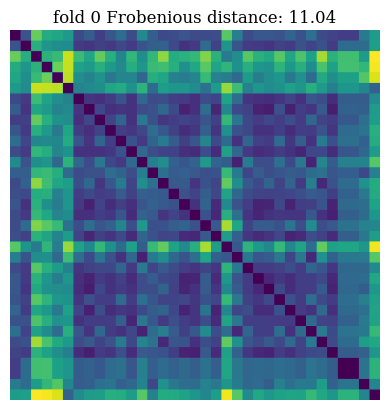

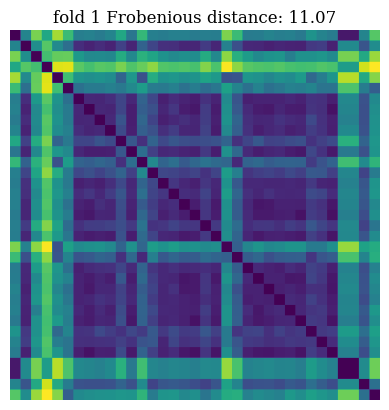

In [ ]:
if not os.path.exists('temp_asd'):
    os.makedirs('temp_asd')
if not os.path.exists('output_asd'):
    os.makedirs('output_asd')  

models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])

In [ ]:
models

[DGN(
   (conv1): NNConv(1, 8, aggr=mean, nn=Sequential(
     (0): Linear(in_features=6, out_features=8, bias=True)
     (1): ReLU()
   ))
   (conv2): NNConv(8, 8, aggr=mean, nn=Sequential(
     (0): Linear(in_features=6, out_features=64, bias=True)
     (1): ReLU()
   ))
   (conv3): NNConv(8, 8, aggr=mean, nn=Sequential(
     (0): Linear(in_features=6, out_features=64, bias=True)
     (1): ReLU()
   ))
 ),
 DGN(
   (conv1): NNConv(1, 8, aggr=mean, nn=Sequential(
     (0): Linear(in_features=6, out_features=8, bias=True)
     (1): ReLU()
   ))
   (conv2): NNConv(8, 8, aggr=mean, nn=Sequential(
     (0): Linear(in_features=6, out_features=64, bias=True)
     (1): ReLU()
   ))
   (conv3): NNConv(8, 8, aggr=mean, nn=Sequential(
     (0): Linear(in_features=6, out_features=64, bias=True)
     (1): ReLU()
   ))
 )]

In [ ]:
if not os.path.exists('temp_asd'):
    os.makedirs('temp_asd')
if not os.path.exists('output_asd'):
    os.makedirs('output_asd')  

models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])

In [ ]:
test_rep = [27.01, 21.8, 18.76, 16.96, 15.64, 14.49, 13.78, 13.21, 12.76, 12.4,
       12.11, 11.87, 11.68, 11.51, 11.37, 11.25, 11.15, 11.07, 11.01, 10.96,
       10.93, 10.91, 10.9, 10.9, 10.9, 10.89, 10.89, 10.89, 10.89, 10.89,
       10.89, 10.9, 10.9, 10.9, 10.91, 10.91, 10.92, 10.92, 10.93, 10.93]

w_out_loss = [11.46409653, 11.45280241, 11.44865159, 11.44989726, 11.45027059,
       11.45093176, 11.44701753, 11.44746854, 11.45353347, 11.45261458,
       11.44811385, 11.44884912, 11.44506118, 11.4503723, 11.44790777,
       11.43626645, 11.45144606, 11.43126236, 11.44293448, 11.02141735,
       11.40390276, 11.44426717, 11.45112095, 11.06944428, 11.45272698,
       11.44528652, 11.44475395, 11.43341447, 11.44478321, 11.42643981,
       11.43668547, 11.00256122, 11.43549399, 11.43775035, 11.37221057,
       11.44131023, 11.45015921, 11.45083308, 11.44632673, 11.39435695]

bio_loss = [0.10259, 0.00958, 0.00273, 0.00621, 0.00088, 0.00049, 0.00176,
       0.00099, 0.00579, 0.00594, 0.00417, 0.00278, 0.00582, 0.00271,
       0.00875, 0.00114, 0.20978, 3.31364, 0.01111, 0.01055, 4.75114,
       0.02287, 0.41296, 5.68211, 0.02204, 0.0283, 0.61258, 0.2632,
       0.01013, 0.03164, 1.32519, 0.32323, 5.75239, 1.7304, 7.18147,
       1.08963, 0.30993, 0.37575, 1.86652, 1.92235]

In [ ]:
bio_loss = 0.0922921076, 0.0922921151, 0.0922921076, 0.0922921076, 0.0922921076, 0.0922921076, 0.0922921151, 0.0922921076, 0.0922921076, 0.0922921076, 0.0922921076, 0.0922921151, 0.0922921076, 0.0922921151, 0.0922921076, 0.0922921300, 0.0922921076, 0.0922921076

In [ ]:
# overall_loss = test_rep + w_out_loss
overall_loss = list(map(lambda x, y: x+y, test_rep, w_out_loss))

# Plotting
# plt.plot(test_rep, label='Test Rep')
plt.plot(w_out_loss, label='W_out')
plt.plot(bio_loss, label='Bio Loss')
plt.plot(overall_loss, label='Overall Loss (Test Rep + W_out)', linestyle='--')

epoch_indices = np.arange(0, len(test_rep), 5)  # Assuming each point represents 10 epochs
plt.xticks(epoch_indices, labels=[str(epoch * 10) for epoch in epoch_indices])

plt.xlabel('Epochs')
plt.ylabel('Loss Values')
plt.title('Losses Across Epochs (Fold 1)')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'test_rep' is not defined

In [ ]:
# fold 1
test_rep = [82.65, 60.42, 42.89, 31.62, 24.77, 20.32, 17.24, 14.97, 13.35,
       12.36, 11.72, 11.31, 11.07, 10.95, 10.89, 10.85, 10.84, 10.86,
       10.88, 10.89]
w_out = [0.09346361, 0.09346361, 0.0934636, 0.09346361, 0.09346361,
       0.0934636, 0.09346361, 0.09346361, 0.09346361, 0.09346361,
       0.09346361, 0.0934636, 0.09346361, 0.09346361, 0.09346361,
       0.0934636, 0.09346361, 0.09346361, 0.09346361, 0.09346361]

bio_loss = [1.85000e-03, 4.70000e-04, 7.44000e-03, 2.23000e-03, 3.62500e-02,
       7.65140e-01, 6.40547e+00, 1.12410e+00, 2.45690e-01, 1.04000e-03,
       3.90000e-04, 3.20000e-04, 1.04000e-03, 2.33000e-03, 3.24000e-03,
       3.71900e-02, 1.68535e+00, 7.19000e-03, 1.88700e-02, 5.91299e+00]

# test_rep_combined =  [83.60313615, 61.35933607, 43.899036, 32.57693607, 26.06713607,
#        28.906036, 82.22933607, 27.14563607, 16.74153615, 13.30503615,
#        12.65853615, 12.247836, 12.01503615, 11.90793607, 11.85703615,
#        12.156536, 28.62813607, 11.86653607, 12.00333607, 70.95453607]


test_rep_combined = [92.00 , 69.77, 52.25, 40.96, 34.16, 30.44, 32.99, 25.44, 22.94,
       21.71, 21.06, 20.66, 20.42, 20.3 , 20.24, 20.23, 21.87, 20.22,
       20.24, 26.15]


In [ ]:
test_rep = [26.59, 18.77, 15.78, 13.86, 12.9, 12.29, 11.86, 11.54, 11.31, 11.18, 11.1, 11.05, 11.04, 11.03, 11.03, 11.04, 11.04]
test_rep_combined = [36.37, 27.78, 24.78, 22.86, 21.91, 21.29, 20.86, 20.55, 20.31, 20.2, 20.2, 20.13, 21.37, 20.74, 20.72, 20.76, 20.98]
w_out = [0.0899940953] * 17
bio_loss = [0.77883, 0.01138, 0.00103, 0.00121, 0.00901, 0.00097, 0.00073, 0.00957, 0.00157, 0.02445, 0.10025, 0.08163, 1.3314, 0.71259, 0.68432, 0.72859, 0.93769]


In [ ]:
test_rep = [19.22, 14.59, 12.16, 11.32, 11.01, 10.85, 10.84, 10.90, 10.95]
w_out = [0.0997957438, 0.0997957513, 0.0997957513, 0.0997957513, 0.0997957513, 0.0997957438, 0.0997957438, 0.0997957587, 0.0997957513]
bio_loss = [0.02613, 2.20048, 0.23084, 0.12617, 0.15919, 0.01695, 0.01001, 0.02186, 0.08946]
test_rep_combined = [29.23, 26.77, 22.37, 21.42, 21.15, 20.85, 20.83, 20.90, 21.02]

# Concatenated biological_fingerprints data, corrected for proper closure


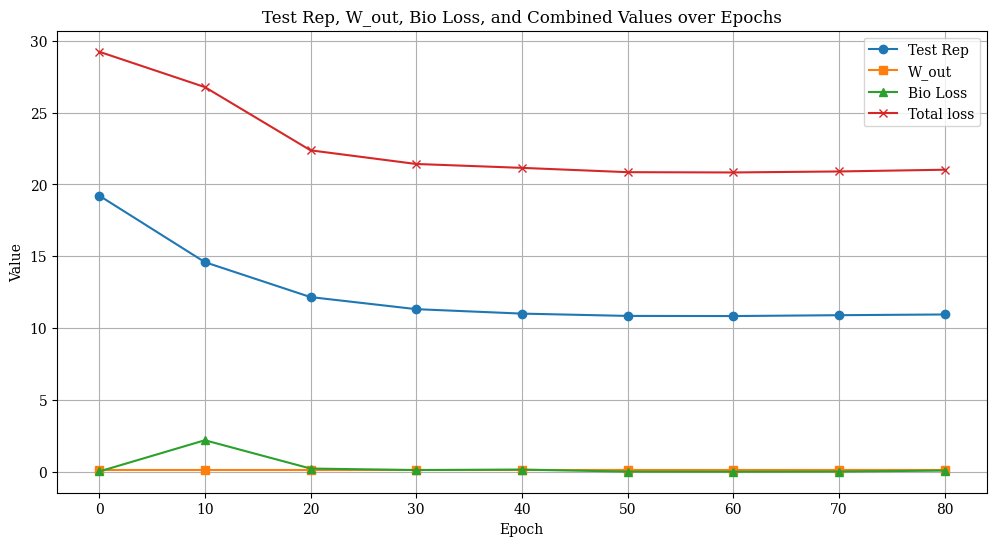

In [ ]:
# Define the x-axis values and scale them by 10
epochs = np.arange(0, len(test_rep)) * 10

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(epochs, test_rep, label='Test Rep', marker='o')
plt.plot(epochs, w_out, label='W_out', marker='s')
plt.plot(epochs, bio_loss, label='Bio Loss', marker='^')
plt.plot(epochs, test_rep_combined, label='Total loss', marker='x')

# Set the x-axis labels
plt.xticks(epochs, labels=[str(int(epoch)) for epoch in epochs])

# Naming the x and y-axis
plt.xlabel('Epoch')
plt.ylabel('Value')

# Title of the plot
plt.title('Test Rep, W_out, Bio Loss, and Combined Values over Epochs')

# Adding a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


NameError: name 'mcs' is not defined

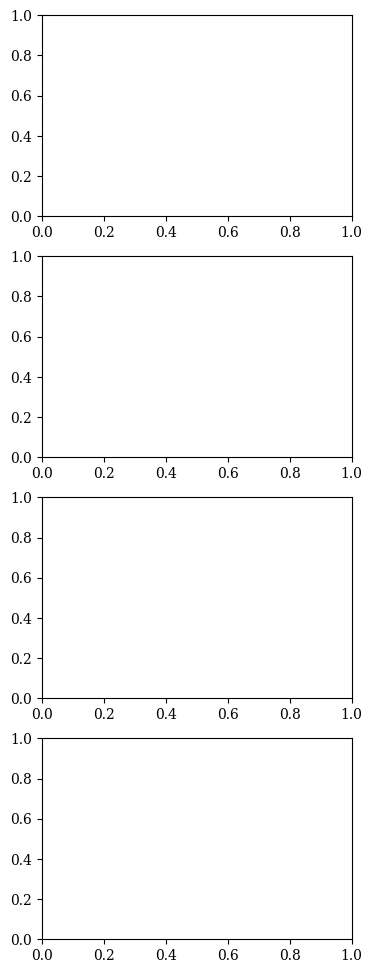

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(4, 12))

bg_colors = ['#EEF5FF', '#FFEBD8', '#F1EAFF', '#F3F0CA']

for i, (cumulative_capacity, memory_capacities) in enumerate(mcs[1:]):
    lags = range(5, len(memory_capacities) + 5)
    axs[i].plot(lags, memory_capacities, '-o', color='gray', markeredgecolor='lightgray',markersize=5)
    axs[i].fill_between(lags, memory_capacities, 0, color='gray', alpha=0.3) 
    axs[i].set_facecolor(bg_colors[i])
    axs[i].set_xlabel('Time Lag')
    axs[i].set_ylabel('rho^2')
    axs[i].set_title(f'MC vs Time Lag Fold {i+1} (Capacity: {cumulative_capacity:.5f})')
    axs[i].grid(True)    

plt.tight_layout()
plt.show()

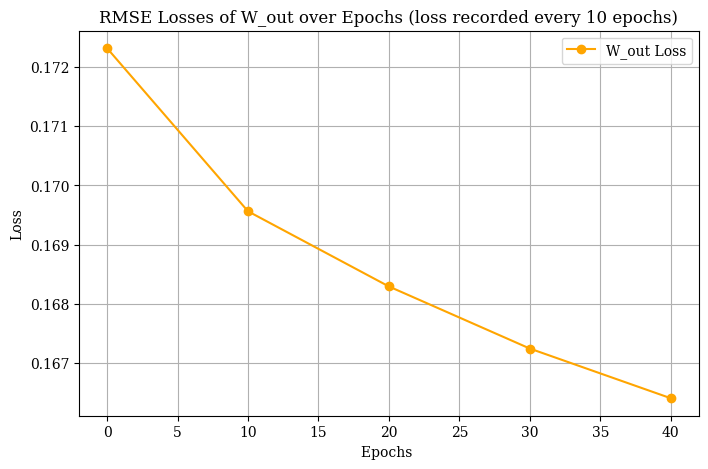

In [ ]:
epochs = [i * 10 for i in range(len(w_out_losses))]

plt.figure(figsize=(8, 5))
plt.plot(epochs, w_out_losses, label='W_out Loss', color='orange', marker='o')
plt.title('RMSE Losses of W_out over Epochs (loss recorded every 10 epochs)')
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



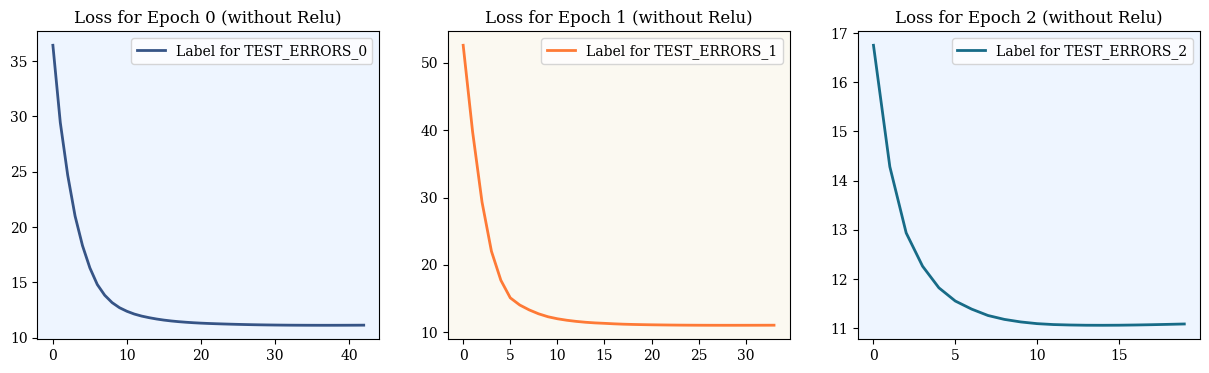

In [ ]:
TEST_ERRORS_0 = [36.42158889770508, 29.445058822631836, 24.69063377380371, 20.98699378967285, 18.318431854248047, 16.302677154541016, 14.803460121154785, 13.83602523803711, 13.169812202453613, 12.70919132232666, 12.385809898376465, 12.135310173034668, 11.949442863464355, 11.807705879211426, 11.687897682189941, 11.589164733886719, 11.509798049926758, 11.445758819580078, 11.393843650817871, 11.349918365478516, 11.313966751098633, 11.28551197052002, 11.261366844177246, 11.240215301513672, 11.220270156860352, 11.20275592803955, 11.186532974243164, 11.172454833984375, 11.160749435424805, 11.150716781616211, 11.142297744750977, 11.135733604431152, 11.130106925964355, 11.126509666442871, 11.123860359191895, 11.121928215026855, 11.120893478393555, 11.120570182800293, 11.121320724487305, 11.122835159301758, 11.124905586242676, 11.127985000610352, 11.131308555603027]
TEST_ERRORS_1 = [52.60558319091797, 39.765380859375, 29.335865020751953, 22.026350021362305, 17.7194766998291, 15.110128402709961, 14.049394607543945, 13.324795722961426, 12.742705345153809, 12.303023338317871, 12.004501342773438, 11.78286361694336, 11.614274978637695, 11.483126640319824, 11.389469146728516, 11.32492446899414, 11.254220962524414, 11.198371887207031, 11.160760879516602, 11.131482124328613, 11.107246398925781, 11.088982582092285, 11.072653770446777, 11.059703826904297, 11.051067352294922, 11.04418659210205, 11.039928436279297, 11.0374755859375, 11.03667163848877, 11.0372896194458, 11.038703918457031, 11.040851593017578, 11.043872833251953, 11.047924995422363]
TEST_ERRORS_2 = [16.75018310546875, 14.28132152557373, 12.935230255126953, 12.259843826293945, 11.819960594177246, 11.551923751831055, 11.387495040893555, 11.257596015930176, 11.178449630737305, 11.126574516296387, 11.091970443725586, 11.073372840881348, 11.064483642578125, 11.059586524963379, 11.058747291564941, 11.060336112976074, 11.064607620239258, 11.070390701293945, 11.077479362487793, 11.085199356079102]

fig, axes = plt.subplots(1, 3, figsize=(15, 4)) 

axes[0].plot(TEST_ERRORS_0, color='#365486', linewidth=2) 
axes[0].legend(['Label for TEST_ERRORS_0'])
axes[0].set_facecolor('#EEF5FF')
axes[0].set_title('Loss for Epoch 0 (without Relu)')

axes[1].plot(TEST_ERRORS_1, color='#FE7A36', linewidth=2) 
axes[1].legend(['Label for TEST_ERRORS_1'])
axes[1].set_facecolor('#FBF9F1') 
axes[1].set_title('Loss for Epoch 1 (without Relu)')

axes[2].plot(TEST_ERRORS_2, color='#176B87', linewidth=2) 
axes[2].legend(['Label for TEST_ERRORS_2'])
axes[2].set_facecolor('#EEF5FF') 
axes[2].set_title('Loss for Epoch 2 (without Relu)')

plt.show()



In [ ]:
median_cbt_mc = [9.26, 10.08, 9.42, 10.28, 10.11, 10.29, 10.30, 10.32, 10.31, 10.51, 10.30, 10.31, 10.30, 10.30, 10.36, 10.30, 10.30, 10.30, 10.30]


In [ ]:
biological_fingerprints_epochs = [
    [9.267069274360587, 9.282294193935272, 9.267592292935118, 9.276770231023779, 9.282626023601004, 9.272659394140653, 9.269717185988567, 9.261488405599973, 9.280192423502218, 9.259399955893732, 9.307821815303443, 9.254835806542934, 9.271875695163173],
    [9.305661505106247, 9.281291699772325, 9.293760257343383, 9.654372741198149, 9.304995786348949, 9.284565264009089, 10.18148896603953, 9.493744354292106, 9.275731324097627, 9.275253670916543, 9.80298147922782, 9.283684693619529, 9.312717645820305],
    [10.143773962277002, 10.148387331110598, 10.274571791114166, 10.280508785357648, 10.26429943158356, 10.282151647566922, 9.986829041140885, 10.279211706844617, 10.27529999489094, 9.291584904337283, 9.291618499628003, 10.23455703086628, 10.262039139956237],
    [10.232954920018493, 10.261023775251497, 10.27117123418791, 10.281709650044448, 10.273306040638476, 10.28240801330391, 10.28316914477892, 10.291892541012796, 10.281272469665826, 10.147996035444114, 10.05289196004057, 10.252263050249645, 10.257423549661263],
    [10.28963192173743, 10.19204631604412, 10.292484230678038, 10.295702691776222, 10.290045956418227, 10.296711192671644, 10.288337326844651, 10.298160582664494, 10.288381898612284, 10.290398587175089, 10.280048318525898, 10.281934220146209, 10.260326217323646],
    [10.298664743978174, 10.294804998303409, 10.302936678290724, 10.298310566510514, 10.29738191835146, 10.306005405332876, 10.304277624450915, 10.305007958035207, 10.30305014254533, 10.294022360058305, 10.296137869523275, 10.295722945722467, 10.293567879418182],
    [10.351245912405117, 10.302044131260494, 10.31686628482863, 10.310090488028793, 10.305132521603587, 10.32310350671435, 10.309678190794157, 10.319940664587351, 10.31270013658299, 10.306890246884386, 10.301770655582203, 10.315398652759992, 10.312269845954411],
    [10.32263695707184, 10.318646637811456, 10.728048099402837, 10.314281184692295, 10.31140074767899, 10.960781681774213, 10.480283322271557, 10.465141460501032, 10.314897172997508, 10.314762399659351, 10.312589735106858, 10.311746838991162, 10.311515514230324],
    [10.317805846041749, 10.323798201532714, 10.311020152224305, 10.307606545432902, 11.271424219984198, 10.316655981037476, 10.335089944903679, 10.321557412189666, 10.329613191183455, 10.309810183798685, 10.400008541529427, 10.370167568062682, 10.38112736489352],
    [10.30465762404968, 10.3088879804401, 10.319981138451272, 10.33355603554751, 10.391983942294974, 10.317668018810112, 10.327120467205736, 10.34865628366135, 10.309875036922179, 10.308504639069325, 10.319708139261362, 10.309368803297664, 10.30547131666978],
    [10.307506010274276, 10.32074426848728, 10.31060737606762, 10.308377025572343, 10.309199385821627, 10.308322582234574, 10.371604022602162, 10.399938966142358, 10.308411996881203, 10.321085313295184, 10.714370904874576, 10.321614210951568, 10.333316015728757],
    [10.319231937799058, 10.30742347652711, 10.367826217819786, 10.303437132846847, 10.398427662700737, 10.307649417020986, 10.310740547692186, 10.305566059749324, 10.327662390171012, 11.204475936933678, 10.308888022493788, 10.405742031297086, 10.325616761710771],
    [10.830363218934307, 10.308402312009724, 10.315951242581642, 10.309376341898432, 10.309839857245057, 10.310780900750053, 10.299871413664862, 10.312047734747408, 10.319287708328668, 10.317466135682912, 10.306024499182662, 10.353733473804107, 10.30366004035332],
    [10.311039501888196, 10.317421050810683, 10.305455789217255, 10.306300144974315, 10.317817514319751, 10.307053892218345, 10.311848192016035, 10.340642017785886, 10.316368414228902, 10.51276890679003, 10.30889084564184, 10.303162255804356, 10.306188214735501],
    [10.311785753011213, 10.354460287118266, 10.314149290186348, 10.310175705017782, 10.838626988981522, 10.307896010516192, 10.30462405330923, 10.329437030201177, 10.310290293660708, 10.462362545620376, 10.362051334884466, 10.312773693137315, 10.29618011718152],
    [10.447793134390311, 10.333137861415976, 10.308664316937541, 10.312109141220157, 10.305762768698196, 10.308490736158047, 10.308542165176068, 10.309951257601853, 10.322192073501544, 10.311795808955022, 10.314582412932173, 10.304590833372846, 10.30570428885135],
    [10.956058263555821, 10.338442474716713, 10.305084140888258, 10.30462528612901, 10.30307262593803, 10.332726079837268, 10.302778026070678, 10.300196449511551, 10.300406856706042, 10.30648347973092, 11.240387244626111, 10.305374520680768, 10.302466182677898],
    [10.369719557257174, 10.33271585406471, 10.315645374345797, 10.305675296834561, 10.300987149462546, 10.304345586614984, 10.320865275647394, 10.302025425600078, 10.300646386092168, 10.304652259459104, 10.312553401549765, 10.303520750267396, 10.305375931851932],
    [10.316906955348003, 10.383651282255293, 10.303538400088568, 10.308212381279166, 10.304188902129393, 10.303780304591177, 10.304081166529082, 10.298663002104245, 10.299729702140825, 10.325294623231917, 10.410857619429, 10.309480586113537, 10.306214119170619],
    [11.226704535307375, 10.303667077550683, 10.310458203174422, 10.326678866499643, 10.304462429671673, 10.30133249278381, 10.327755306664107, 10.30099848987754, 10.296885211196757, 10.39542422449677, 10.303327298503842, 10.312785300334282, 10.29825016593803]
]


In [ ]:
avg_biological_fingerprints = [sum(epoch)/len(epoch) for epoch in biological_fingerprints_epochs]


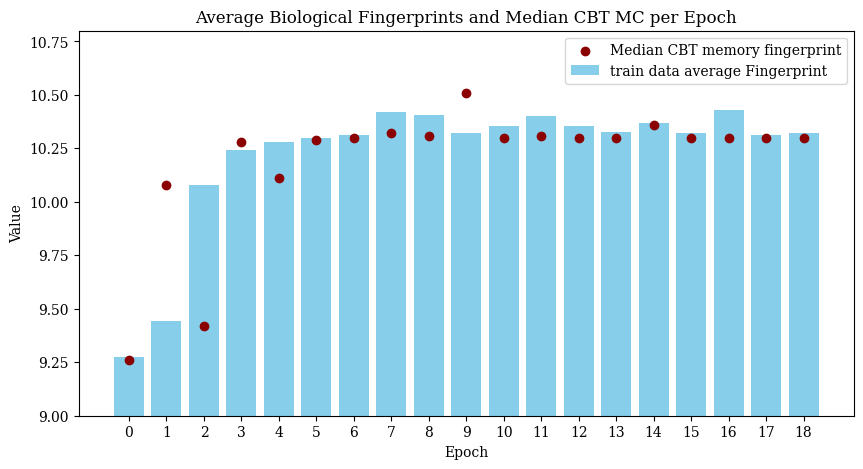

In [ ]:
avg_biological_fingerprints = avg_biological_fingerprints[:len(median_cbt_mc)]
epochs = np.arange(len(avg_biological_fingerprints))

plt.figure(figsize=(10, 5))
plt.bar(epochs, avg_biological_fingerprints, color='skyblue', label='train data average Fingerprint')
plt.scatter(epochs, median_cbt_mc, color='darkred', label='Median CBT memory fingerprint', zorder=5)
plt.xlabel('Epoch')
plt.xticks(epochs, labels=[str(e) for e in epochs], rotation=0)  # Set x-axis labels to be horizontal
plt.ylabel('Value')
plt.ylim(9, 10.8)
plt.title('Average Biological Fingerprints and Median CBT MC per Epoch')
plt.legend()
plt.show()